# Exercise 07 CNN & Transfer Learning - Instruction

## Pedagogy

This notebook serves as an instruction for implementing transfer learning with pre-trained CNNs for image classificatoin tasks.

Please use this notebook as a reference and guide to complete the assignment.

### Pre-configure

In this notebook, we will use the following new libraries:
- `tqdm` for showing a probress bar during the iterative processes

In [3]:
# install tqdm
%pip install tqdm -y


Usage:   
  /Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/bin/python -m pip install [options] [-e] <vcs project url> ...
  /Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/bin/python -m pip install [options] [-e] <local project path> ...
  /Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/bin/python -m pip install [options] <archive url/path> ...

no such op

In [2]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Part 1. Multi-class image classification with pre-trained CNNs and transfer learning

In this notebook, we will build a multi-class image classifier with <span style="color:red">**a pre-trained CNN (SqueezeNet)**</span> and <span style="color:red">**transfer learning**</span>.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

### Step 1. Build the data pipeline

We will use the PyTorch built-in CIFAR-10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

In this step, we need to:
- <span style="color:red">**Define the transformations applied to the CIFAR-10 dataset according to the requirement of the pre-trained CNN (SqueezeNet)**</span>
- Load the CIFAR-10 dataset and divide it into the training, validation, and test set
- Create dataloaders for the training, validatoin, and test set
- (Optional) Display some of sample images to understand the dataset

To use pre-trained CNNs, we need to pre-process the images as required by the specific pre-trained model.

`torchvision.models` provides a list of pre-trained models for different tasks.

These models are trained on huge datasets, for example, the ImageNet dataset.

Therefore, these pre-trained models have learned to extract different features from a general perspective.

When training these models, the training images are pre-processed by the following steps (you can find more information [here](https://pytorch.org/vision/stable/models/generated/torchvision.models.squeezenet1_1.html#torchvision.models.squeezenet1_1)):
- Resize to `resize_size = [256]`
- A central crop of `crop_size = [224]`
- Rescale to `[0.0, 1.0]`
- Normalize using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

Therefore, to use these pre-trained models for transfer learning, we also need to pre-process the images by the same steps.
- The size of images in CIFAR-10 dataset is $32\times32$, the height is the same as the width, so we can directly resize the images to $224\times224$
- The images in CIFAR-10 are already scaled to `[0.0, 1.0]`, no need for rescaling
- We need to normalize the images in CIFAR-10 using the same mean and standard deviation

We can use the built-in transform functions in `torchvision.transforms` to perform these pre-processing.

More specifically, we first define a sequence of transformations to perform. Then we use these transformations to pre-process the images when loading the dataset.

In [5]:
# define transformations required by the pre-trained SqueezeNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit input size required by SqueezeNet
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    ),  # Normalization parameters for pre-trained models
])

In [6]:
# load CIFAR-10 dataset
train_val_ds = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# create the train and test data loaders
batch_size = 2048 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

When training large CNN models, you may not have enough RAM.

If you encounter this problem, you can reduce the batch size, which will reduce the amount of memory required to compute the batch.

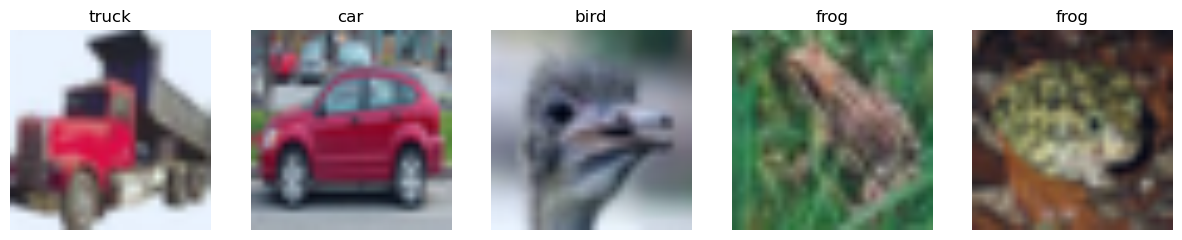

In [8]:
# define a function to display several images in the dataset
def display_dataset(dataset, n = 10,classes = None):
    fig, ax = plt.subplots(1, n, figsize = (15, 3))
    mn = min([dataset[i][0].min() for i in range(n)]) # scale the pixel values for display
    mx = max([dataset[i][0].max() for i in range(n)]) # scale the pixel values for display
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0] - mn)/(mx - mn), (1, 2, 0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])
# class names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# display several example images
display_dataset(train_ds, n = 5, classes = classes)

### Step 2. Load Pre-trained model and Re-build the classifier

As we will use pre-trained CNNs in transfer learning, there is no need to define a custom class for the neural network.

Instead, we need to perform the following steps:
- <span style="color:red">**Load the pre-trained model**</span> (pre-trained values of weight and bias parameters)
- <span style="color:red">**Replace the classifier part**</span> according to the problem to solve
    - We have 10 classes in CIFAR-10 dataset, therefore the final FC layer should contains 10 neurons with linear activation function, which will output the logits
    - You can define the structure of the classifier part just like defining a traditional ANN
- <span style="color:red">**Freeze the learning parameters of the feature extractor part**</span>
    - Set the `requires_grad` attribute of each parameter to `False`
    - No gradients will be computed in both forward and backward propagation
- Set up GPU acceleration if it's available

In [9]:
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

We can see that the pre-trained SqueezeNet contains two parts:
- `features`: The feature extractor
- `classifier`: Use the previously extracted features for classification

To use this pre-trained model, we need to modify the `classifier` part to let it output 10 logits for 10 classes. We can:
- Replace the entire `classifier` part
-  Modify some of the layers in this part
- Add additional layers in this part

As long as the modified `classifier` can output 10 logits, we can use this model to solve our problem.

Here we replace the entire `classifier` part by defining a sequence of FC layers.

In [10]:
# replace the classifier part
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(10)
)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

We can see the `classifier` part is already replaced.

We also need to freeze the learning parameters of the `features` part by setting the `requires_grad` attribute to `False`. 

Otherwise, `PyTorch` will compute the gradients automatically, even though we won't use them to update these learning parameters.

In [11]:
# freeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = False

Don't forget to move the network to GPU for acceleration.

In [12]:
# move the model to the computation device
squeezenet = squeezenet.to(device)

### Step 3. Train the re-built classifier

Here we can use the same `train()` function as the previous session.

Since the computation can be time consuming, we can add <span style="color:red">**a `tqdm` progress bar**</span> for each training/validation epoch to show how many batches are completed.

In [13]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()
    
    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            logits = model(X)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)
        
        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                logits = model(X)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")
        
        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')
            
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

Then we need to define the training hyper-parameters.

There is one thing different:
- When creating the optimizer instance, instead of optimizing the parameters of the entire netowrk, we <span style="color:red">**only optimize the `classifier` part**</span>.
- By doing so, the feature extractor part will remain unchanged.

In [14]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    squeezenet.classifier.parameters(), # only optimize the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 50
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 1
)
saved_path_prefix = 'finetuned_classifier_squeezenet'

In [15]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 1: train loss = 1.164175, val loss = 0.723236, time consumed = 0:00:40
Model saved after epoch 1



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 2: train loss = 0.673203, val loss = 0.544534, time consumed = 0:01:29
Model saved after epoch 2



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


Epoch 3: train loss = 0.498620, val loss = 0.475823, time consumed = 0:02:22
Model saved after epoch 3



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 4: train loss = 0.383544, val loss = 0.446014, time consumed = 0:03:17
Model saved after epoch 4



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 5: train loss = 0.293059, val loss = 0.416086, time consumed = 0:04:19
Model saved after epoch 5



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.92s/it]


Epoch 6: train loss = 0.229529, val loss = 0.408442, time consumed = 0:05:28
Model saved after epoch 6



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 7: train loss = 0.179237, val loss = 0.411518, time consumed = 0:06:37


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.69s/it]


Epoch 8: train loss = 0.143851, val loss = 0.402843, time consumed = 0:07:43
Model saved after epoch 8



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 9: train loss = 0.118202, val loss = 0.405551, time consumed = 0:08:53


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 10: train loss = 0.095532, val loss = 0.405683, time consumed = 0:10:02
Learning rate reduced after epoch 10



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 11: train loss = 0.079947, val loss = 0.395536, time consumed = 0:11:10
Model saved after epoch 11



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.81s/it]


Epoch 12: train loss = 0.076318, val loss = 0.394558, time consumed = 0:12:20
Model saved after epoch 12



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.91s/it]


Epoch 13: train loss = 0.074242, val loss = 0.394420, time consumed = 0:13:31
Model saved after epoch 13



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 14: train loss = 0.073254, val loss = 0.393824, time consumed = 0:14:43
Model saved after epoch 14



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 15: train loss = 0.070053, val loss = 0.394187, time consumed = 0:15:54


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.82s/it]


Epoch 16: train loss = 0.068594, val loss = 0.394038, time consumed = 0:17:07
Learning rate reduced after epoch 16



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 17: train loss = 0.067381, val loss = 0.394083, time consumed = 0:18:13


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 18: train loss = 0.066688, val loss = 0.394099, time consumed = 0:19:22
Learning rate reduced after epoch 18



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.73s/it]

Epoch 19: train loss = 0.066890, val loss = 0.394091, time consumed = 0:20:32
Early stopping!


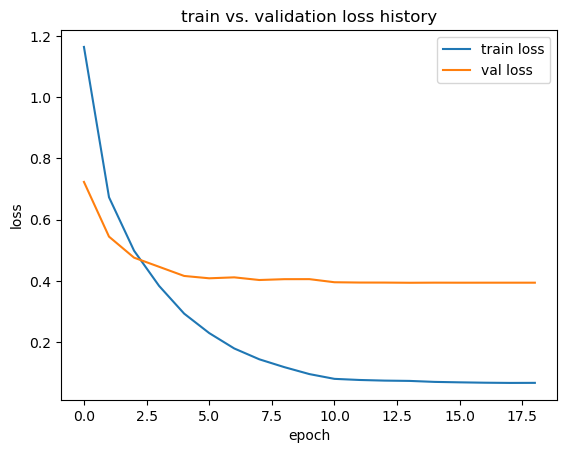

In [16]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

The final model after training may mot be the best one saved during the training process.

To use the best model, we need to reload it from the saved file.

In [17]:
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))
squeezenet.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### Step 5. Evaluation using test set

We also add `tqdm` progress bar in the `test()` function.

We can now check the effectiveness of transfer learning.

If you already finish the assignment of session 6, you can compare the classification accuracy of this Squeeze Net-based model with you hand-crafted CNN to see which one is better.

In [18]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in tqdm(dataloader, desc = f'Test batch'):
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [19]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.67s/it]


test loss = 0.4111249685287476
              precision    recall  f1-score   support

       plane       0.88      0.89      0.88      1000
         car       0.94      0.93      0.93      1000
        bird       0.83      0.81      0.82      1000
         cat       0.75      0.71      0.73      1000
        deer       0.82      0.86      0.84      1000
         dog       0.79      0.80      0.79      1000
        frog       0.89      0.91      0.90      1000
       horse       0.90      0.89      0.90      1000
        ship       0.92      0.92      0.92      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



The predicted class is: deer
The predicted probability is: 0.9827952


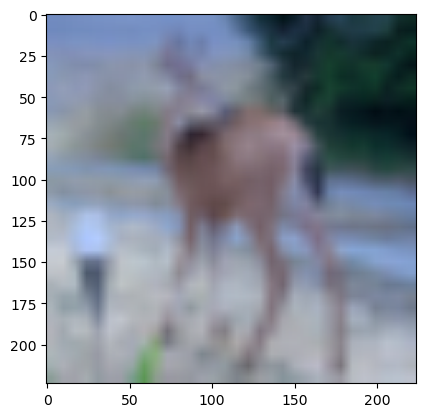

In [21]:
# display an example
sample = test_ds[100][0].numpy().transpose(1, 2, 0)
mn = sample.min()
mx = sample.max()
plt.imshow((sample - mn)/(mx - mn))
print('The predicted class is:', classes[test_pred[100]])
print('The predicted probability is:', test_prob[100, test_pred[100]])

## Part 2. Fine-tune the entire pre-trained CNN

This part is <span style="color:red">**optional**</span>. You do not need to run this part. The purpose of this part is to show you how to fine-tune the entire network.

If you are not satisfactory of the performance, or you want to fully release the potential of the pre-trained model, you can try to fine-tune not only the `classifier` part, but the entire pre-trained model.

Warning: This can be very time-consuming!

### Step 1. Build the data pipeline

Fine-tuning the entire network requires more RAM than fine-tuning the `classifier` part only.

Therefore, we might need to adjust the `batch_size` of the data pipeline.

Reduce the `batch_size` if you encounter the out-of-memory problem.

In [22]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

### Step 2. Load Pre-trained model and Re-build the classifier

We need to perform the following steps:
- Load the pre-trained model (pre-trained values of weight and bias parameters)
- Replace the classifier part according to the problem to solve
- To fine-tune the entire network, <span style="color:red">**unfreeze**</span> the learning parameters of the feature extractor part
    - Set the `requires_grad` attribute of each parameter to `True`
- Set up GPU acceleration if it's available

In [23]:
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)

# replace the classifier part
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(10)
)

# unfreeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = True

# move the network to the computation device
squeezenet = squeezenet.to(device)

### Step 3. Fine-tune the entire pre-trained CNN

Here we can use the same `train()` function as the previous part.

In order to retain the knowledge that the pre-trained model has learned during the pre-training phase, we should use <span style="color:red">**a relatively small learning rate**</span>.

When creating the optimizer, we also need to specify that we want to <span style="color:red">**optimize the entire network**</span>.

In [24]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2 # a relative small learning rate
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    squeezenet.parameters(), # optimize the entire network, not only the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 50
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 1
)
saved_path_prefix = 'finetuned_entire_squeezenet'

Warning: This can be very time-consuming!

Better to do this using Google Colab if you don't have the GPU accelation on your computer.

If you encounter the out-of-memory problem, reduce the batch size.

In [25]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29it/s]


Epoch 1: train loss = 1.232494, val loss = 0.828111, time consumed = 0:01:02
Model saved after epoch 1



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 2: train loss = 0.818327, val loss = 0.706472, time consumed = 0:02:07
Model saved after epoch 2



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 3: train loss = 0.657899, val loss = 0.591144, time consumed = 0:03:11
Model saved after epoch 3



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]


Epoch 4: train loss = 0.551587, val loss = 0.531996, time consumed = 0:04:14
Model saved after epoch 4



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch 5: train loss = 0.478067, val loss = 0.563702, time consumed = 0:05:20


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 6: train loss = 0.417748, val loss = 0.420459, time consumed = 0:06:33
Model saved after epoch 6



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 7: train loss = 0.364282, val loss = 0.421973, time consumed = 0:07:53


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 8: train loss = 0.320454, val loss = 0.464988, time consumed = 0:09:07
Learning rate reduced after epoch 8



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 9: train loss = 0.287840, val loss = 0.356412, time consumed = 0:10:17
Model saved after epoch 9



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch 10: train loss = 0.277006, val loss = 0.355083, time consumed = 0:11:26
Model saved after epoch 10



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 11: train loss = 0.271553, val loss = 0.353610, time consumed = 0:12:34
Model saved after epoch 11



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


Epoch 12: train loss = 0.265110, val loss = 0.350365, time consumed = 0:13:41
Model saved after epoch 12



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 13: train loss = 0.263743, val loss = 0.349665, time consumed = 0:14:48
Model saved after epoch 13



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 14: train loss = 0.257670, val loss = 0.346884, time consumed = 0:15:56
Model saved after epoch 14



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 15: train loss = 0.253368, val loss = 0.347518, time consumed = 0:17:05


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch 16: train loss = 0.250833, val loss = 0.346090, time consumed = 0:18:13
Model saved after epoch 16



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch 17: train loss = 0.247631, val loss = 0.342674, time consumed = 0:19:23
Model saved after epoch 17



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 18: train loss = 0.244054, val loss = 0.342328, time consumed = 0:20:34
Model saved after epoch 18



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 19: train loss = 0.240686, val loss = 0.342391, time consumed = 0:21:48


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch 20: train loss = 0.238828, val loss = 0.340220, time consumed = 0:23:12
Model saved after epoch 20



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch 21: train loss = 0.232817, val loss = 0.339791, time consumed = 0:24:32
Model saved after epoch 21



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 22: train loss = 0.229307, val loss = 0.339161, time consumed = 0:25:52
Model saved after epoch 22



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 23: train loss = 0.227758, val loss = 0.337752, time consumed = 0:27:10
Model saved after epoch 23



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 24: train loss = 0.221802, val loss = 0.336593, time consumed = 0:28:23
Model saved after epoch 24



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 25: train loss = 0.220262, val loss = 0.334821, time consumed = 0:29:41
Model saved after epoch 25



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 26: train loss = 0.215350, val loss = 0.334807, time consumed = 0:31:01
Model saved after epoch 26



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 27: train loss = 0.212843, val loss = 0.333679, time consumed = 0:32:19
Model saved after epoch 27



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 28: train loss = 0.212996, val loss = 0.334406, time consumed = 0:33:36


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 29: train loss = 0.204814, val loss = 0.332080, time consumed = 0:34:52
Model saved after epoch 29



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 30: train loss = 0.204581, val loss = 0.331563, time consumed = 0:36:12
Model saved after epoch 30



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 31: train loss = 0.199658, val loss = 0.328743, time consumed = 0:37:32
Model saved after epoch 31



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Epoch 32: train loss = 0.199455, val loss = 0.329297, time consumed = 0:38:59


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Epoch 33: train loss = 0.197965, val loss = 0.328268, time consumed = 0:40:25
Model saved after epoch 33



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 34: train loss = 0.195163, val loss = 0.327280, time consumed = 0:41:45
Model saved after epoch 34



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Epoch 35: train loss = 0.190018, val loss = 0.326979, time consumed = 0:42:59
Model saved after epoch 35



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 36: train loss = 0.187591, val loss = 0.327765, time consumed = 0:44:14


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch 37: train loss = 0.185287, val loss = 0.325121, time consumed = 0:45:26
Model saved after epoch 37



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.12it/s]


Epoch 38: train loss = 0.182601, val loss = 0.325642, time consumed = 0:46:38


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch 39: train loss = 0.180890, val loss = 0.325280, time consumed = 0:47:49
Learning rate reduced after epoch 39



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch 40: train loss = 0.178551, val loss = 0.324612, time consumed = 0:49:00
Model saved after epoch 40



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 41: train loss = 0.179411, val loss = 0.325234, time consumed = 0:50:12


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 42: train loss = 0.178503, val loss = 0.323818, time consumed = 0:51:24
Model saved after epoch 42



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 43: train loss = 0.177050, val loss = 0.324500, time consumed = 0:52:36


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 44: train loss = 0.177317, val loss = 0.323878, time consumed = 0:53:50
Learning rate reduced after epoch 44



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 45: train loss = 0.176566, val loss = 0.323966, time consumed = 0:55:03


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 46: train loss = 0.175015, val loss = 0.323714, time consumed = 0:56:16
Model saved after epoch 46



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 47: train loss = 0.177009, val loss = 0.323339, time consumed = 0:57:31
Model saved after epoch 47



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 48: train loss = 0.179540, val loss = 0.323788, time consumed = 0:58:47


Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 49: train loss = 0.176887, val loss = 0.324562, time consumed = 1:00:02
Learning rate reduced after epoch 49



Validation batch: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

Epoch 50: train loss = 0.177827, val loss = 0.323499, time consumed = 1:01:16


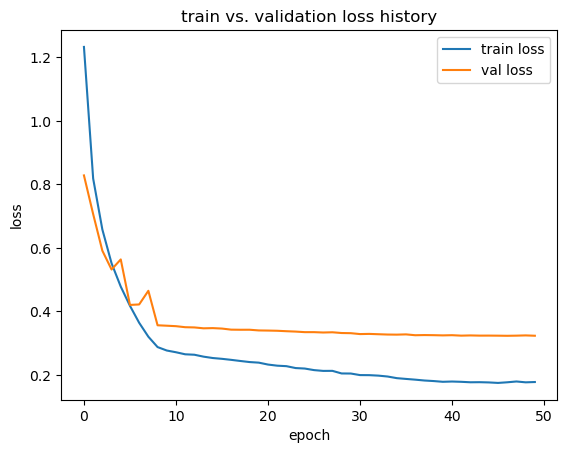

In [26]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

In [27]:
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

<All keys matched successfully>

### Step 5. Evaluation using test set

In [28]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


test loss = 0.33380231261253357
              precision    recall  f1-score   support

       plane       0.91      0.92      0.91      1000
         car       0.95      0.95      0.95      1000
        bird       0.87      0.86      0.87      1000
         cat       0.79      0.76      0.77      1000
        deer       0.89      0.89      0.89      1000
         dog       0.82      0.84      0.83      1000
        frog       0.91      0.94      0.92      1000
       horse       0.93      0.91      0.92      1000
        ship       0.93      0.94      0.94      1000
       truck       0.95      0.93      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



By comparing the performance with the one in the previous part, we can find that:
- Fine-tuning the entire pre-trained CNN achieved a better performance than fine-tuning the `classifier` part only.
- The improvement is not significant, but the training process is more time-consuming.